<a href="https://jupyterhub.user.eopf.eodc.eu/hub/user-redirect/git-pull?repo=https://github.com/eopf-toolkit/eopf-101&branch=main&urlpath=lab/tree/eopf-101/41_rio_tiler_s2_fundamentals.ipynb" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

## Introduction

This notebook demonstrates efficient tiling workflows with EOPF Zarr data using **rio-tiler** and **rio-xarray**. We'll showcase how direct Zarr access with proper chunking delivers superior performance for web mapping and visualization tasks.

**Rio-tiler** is a powerful Python library designed for creating map tiles from raster data sources. Combined with EOPF Zarr's cloud-optimized format, it enables efficient tile generation for web mapping applications without downloading entire datasets.

## What we will learn

- 🗺️ How to integrate rio-tiler with EOPF Zarr datasets
- 🎨 Generate map tiles (RGB and false color composites) from Sentinel-2 data
- 📊 Understand the relationship between Zarr chunks and tile performance
- ⚡ Observe memory usage patterns for large optical datasets
- 🌍 Create interactive web map visualizations

## Prerequisites

This tutorial builds on concepts from previous sections:
- [Understanding Zarr Structure](24_zarr_struct_S2L2A.ipynb) - Sentinel-2 data organization
- [STAC and xarray Tutorial](44_eopf_stac_xarray_tutorial.ipynb) - Accessing EOPF data
- [Zarr Chunking Strategies](sections/2x_about_eopf_zarr/253_zarr_chunking_practical.ipynb) - Chunking fundamentals

As rio-tiler is extensively used in this notebook, familiarity with its core concepts is beneficial. Refer to the [rio-tiler documentation](https://docs.rio-tiler.io/en/latest/) for more details.

![rio-tiler with EOPF Zarr](img/rio-tiler.png)

**Required packages**: `rio-tiler`, `rio-xarray`, `xarray`, `zarr`, `pystac-client`

<hr>

# Section 1: Direct Zarr Access Setup

We'll start by connecting to the EOPF STAC catalog and loading a Sentinel-2 L2A dataset with its native Zarr chunking configuration.

### Import libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pystac_client import Client
from pystac import MediaType
from rio_tiler.io import XarrayReader
from rio_tiler.models import ImageData
import rioxarray
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


### Connect to EOPF STAC Catalog

We'll search for a cloud-free Sentinel-2 L2A scene over a test region.

In [2]:
# Connect to EOPF STAC API
import json


eopf_stac_api_root = "https://stac.core.eopf.eodc.eu/"
catalog = Client.open(url=eopf_stac_api_root)

# Search for Sentinel-2 L2A over Napoli during summer 2025
search_results = catalog.search(
    collections='sentinel-2-l2a',
    bbox=(14.268124, 40.835933, 14.433823, 40.898202),  # Napoli AOI
    datetime='2025-06-01T00:00:00Z/2025-09-30T23:59:59Z',  # Summer 2025
    max_items=1,
    filter={
        "op": "and",
        "args": [
            {
                "op": "lte",
                "args": [
                    {"property": "eo:cloud_cover"},
                    10  # Cloud cover less than or equal to 10%
                ]
            }
        ]
    },
    filter_lang='cql2-json'
)

# Get first item
items = list(search_results.items())
if not items:
    raise ValueError("No items found. Try adjusting the search parameters.")

item = items[0]
print(f"📦 Found item: {item.id}")
print(f"📅 Acquisition date: {item.properties.get('datetime', 'N/A')}")

📦 Found item: S2B_MSIL2A_20250921T100029_N0511_R122_T33TVF_20250921T135752
📅 Acquisition date: 2025-09-21T10:00:29.024000Z


### Open Zarr Dataset with xarray

We'll use xarray's `open_datatree()` to access the hierarchical EOPF Zarr structure directly from cloud storage.

In [3]:
# Get Zarr URL from STAC item
item_assets = item.get_assets(media_type=MediaType.ZARR)
zarr_url = item_assets['product'].href
print(f"🌐 Zarr URL: {zarr_url}")

# Open with xarray DataTree
dt = xr.open_datatree(
    zarr_url,
    engine="zarr",
    chunks="auto"  # Use existing Zarr chunks
)

print("\n📂 Available groups in DataTree:")
for group in sorted(dt.groups):
    if dt[group].ds.data_vars:
        print(f"  {group}: {list(dt[group].ds.data_vars.keys())}")

🌐 Zarr URL: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202509-s02msil2a/21/products/cpm_v256/S2B_MSIL2A_20250921T100029_N0511_R122_T33TVF_20250921T135752.zarr

📂 Available groups in DataTree:
  /conditions/geometry: ['mean_sun_angles', 'mean_viewing_incidence_angles', 'sun_angles', 'viewing_incidence_angles']
  /conditions/mask/detector_footprint/r10m: ['b02', 'b03', 'b04', 'b08']
  /conditions/mask/detector_footprint/r20m: ['b05', 'b06', 'b07', 'b11', 'b12', 'b8a']
  /conditions/mask/detector_footprint/r60m: ['b01', 'b09', 'b10']
  /conditions/mask/l1c_classification/r60m: ['b00']
  /conditions/mask/l2a_classification/r20m: ['scl']
  /conditions/mask/l2a_classification/r60m: ['scl']
  /conditions/meteorology/cams: ['aod1240', 'aod469', 'aod550', 'aod670', 'aod865', 'bcaod550', 'duaod550', 'omaod550', 'ssaod550', 'suaod550', 'z']
  /conditions/meteorology/ecmwf: ['msl', 'r', 'tco3', 'tcwv', 'u10', 'v10']
  /measurements/reflectance/r10m: ['b02', 'b03', 'b04', 'b08']
 

### Explore Sentinel-2 Band Structure

Sentinel-2 L2A provides bands at three spatial resolutions:
- **10m**: B02 (Blue), B03 (Green), B04 (Red), B08 (NIR)
- **20m**: B05, B06, B07, B8A, B11, B12
- **60m**: B01, B09, B10

Let's examine the 10m resolution group, which we'll use for RGB visualization.

In [4]:
# Access 10m resolution bands
ds_10m = dt['/measurements/reflectance/r10m'].to_dataset()

print("\n🔍 10m Resolution Dataset:")
print(f"Dimensions: {dict(ds_10m.dims)}")
print(f"Bands: {list(ds_10m.data_vars.keys())}")
print(f"Coordinates: {list(ds_10m.coords.keys())}")

# Check chunking configuration
if 'b04' in ds_10m:
    chunks = ds_10m['b04'].chunks
    print(f"\n📦 Current chunk configuration: {chunks}")
    print(f"   Y-axis chunks: {chunks[0] if len(chunks) > 0 else 'N/A'}")
    print(f"   X-axis chunks: {chunks[1] if len(chunks) > 1 else 'N/A'}")


🔍 10m Resolution Dataset:
Dimensions: {'y': 10980, 'x': 10980}
Bands: ['b02', 'b03', 'b04', 'b08']
Coordinates: ['x', 'y']

📦 Current chunk configuration: ((4096, 4096, 2788), (4096, 4096, 2788))
   Y-axis chunks: (4096, 4096, 2788)
   X-axis chunks: (4096, 4096, 2788)


### Extract and Set CRS Information

EOPF Zarr stores CRS information in the root DataTree attributes under `other_metadata.horizontal_CRS_code`. We need to extract this and set it using rioxarray for rio-tiler compatibility.

In [5]:
# Extract CRS from EOPF metadata (following geozarr.py approach)
epsg_code_full = dt.attrs.get("other_metadata", {}).get("horizontal_CRS_code", "EPSG:4326")
epsg_code = epsg_code_full.split(":")[-1]  # Extract numeric part (e.g., "32632" from "EPSG:32632")

print(f"📍 Extracted CRS from EOPF metadata: EPSG:{epsg_code}")
print(f"   Full code: {epsg_code_full}")

# Set CRS on the dataset using rioxarray
ds_10m = ds_10m.rio.write_crs(f"epsg:{epsg_code}")

print(f"\n✅ CRS set successfully on dataset")

📍 Extracted CRS from EOPF metadata: EPSG:32633
   Full code: EPSG:32633

✅ CRS set successfully on dataset


In [6]:
# Verify CRS and geospatial metadata
crs = ds_10m.rio.crs
bounds = ds_10m.rio.bounds()
transform = ds_10m.rio.transform()

print(f"\n🌍 Geospatial Metadata:")
print(f"   CRS: {crs}")
print(f"   EPSG Code: {crs.to_epsg()}")
print(f"   Bounds (left, bottom, right, top): {bounds}")
print(f"   Transform: {transform}")
print(f"\n   Width: {ds_10m.dims['x']} pixels")
print(f"   Height: {ds_10m.dims['y']} pixels")


🌍 Geospatial Metadata:
   CRS: EPSG:32633
   EPSG Code: 32633
   Bounds (left, bottom, right, top): (399960.0, 4490220.0, 509760.0, 4600020.0)
   Transform: | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4600020.00|
| 0.00, 0.00, 1.00|

   Width: 10980 pixels
   Height: 10980 pixels


### Verify Geospatial Metadata

Now we can access CRS, bounds, and transform information through rioxarray. This is essential for rio-tiler integration.

# Section 2: Rio-tiler Integration Basics

Now we'll integrate rio-tiler to generate map tiles from our Zarr dataset.

### Prepare DataArray for Rio-tiler

Rio-tiler's `XarrayReader` works with **DataArrays**, not Datasets. We need to stack our RGB bands into a single DataArray with a 'band' dimension.

In [7]:
# Verify dataset is ready
if ds_10m.rio.crs is None:
    raise ValueError("CRS not set! Check previous steps.")

# Stack RGB bands into a single DataArray for rio-tiler
# XarrayReader requires a DataArray, not a Dataset
rgb_bands = xr.concat(
    [ds_10m['b04'], ds_10m['b03'], ds_10m['b02']],  # Red, Green, Blue
    dim='band'
).assign_coords(band=['red', 'green', 'blue'])

# Preserve CRS information
rgb_bands = rgb_bands.rio.write_crs(ds_10m.rio.crs)

print("✅ DataArray prepared for rio-tiler")
print(f"   CRS: {rgb_bands.rio.crs}")
print(f"   Shape: {rgb_bands.shape} (band, y, x)")
print(f"   Bands: {list(rgb_bands.coords['band'].values)}")

✅ DataArray prepared for rio-tiler
   CRS: EPSG:32633
   Shape: (3, 10980, 10980) (band, y, x)
   Bands: [np.str_('red'), np.str_('green'), np.str_('blue')]


### Generate True Color RGB Tile

We'll create a Web Mercator tile (zoom 11) showing true color composite (B04-Red, B03-Green, B02-Blue).

In [8]:
# Create RGB composite using XarrayReader with our stacked DataArray
with XarrayReader(rgb_bands) as src:
    # Get dataset info
    print(f"\n📊 Dataset Info:")
    print(f"   CRS: {src.crs}")
    print(f"   Bounds: {src.bounds}")
    print(f"   Available bands: {src.band_names}")
    
    # Read an extent at a reasonable resolution
    rgb_data = src.tile(
        1107,
        769,
        11,
        tilesize=512,
    )

print(f"\n✅ RGB tile generated:")
print(f"   CRS: {rgb_data.crs}")
print(f"   Bounds: {rgb_data.bounds}")
print(f"   Shape: {rgb_data.data.shape}")
print(f"   Data type: {rgb_data.data.dtype}")


📊 Dataset Info:
   CRS: EPSG:32633
   Bounds: (399960.0, 4490220.0, 509760.0, 4600020.0)
   Available bands: ['red', 'green', 'blue']

✅ RGB tile generated:
   CRS: EPSG:3857
   Bounds: BoundingBox(left=1624133.9770034105, bottom=4970241.327215312, right=1643701.856244415, top=4989809.206456317)
   Shape: (3, 512, 512)
   Data type: float64


### Visualize True Color Composite

Let's visualize the RGB composite with histogram stretching for better contrast.

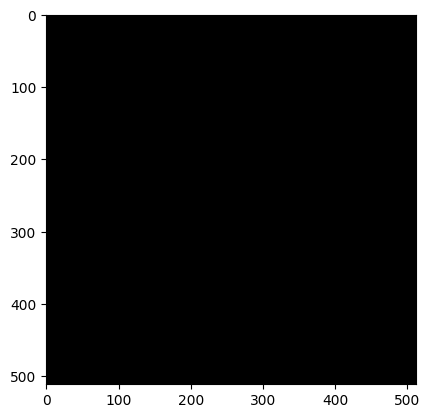

In [9]:
from matplotlib.pyplot import imshow


rgb_data.rescale(((0, 0.1),))
imshow(rgb_data.data_as_image())

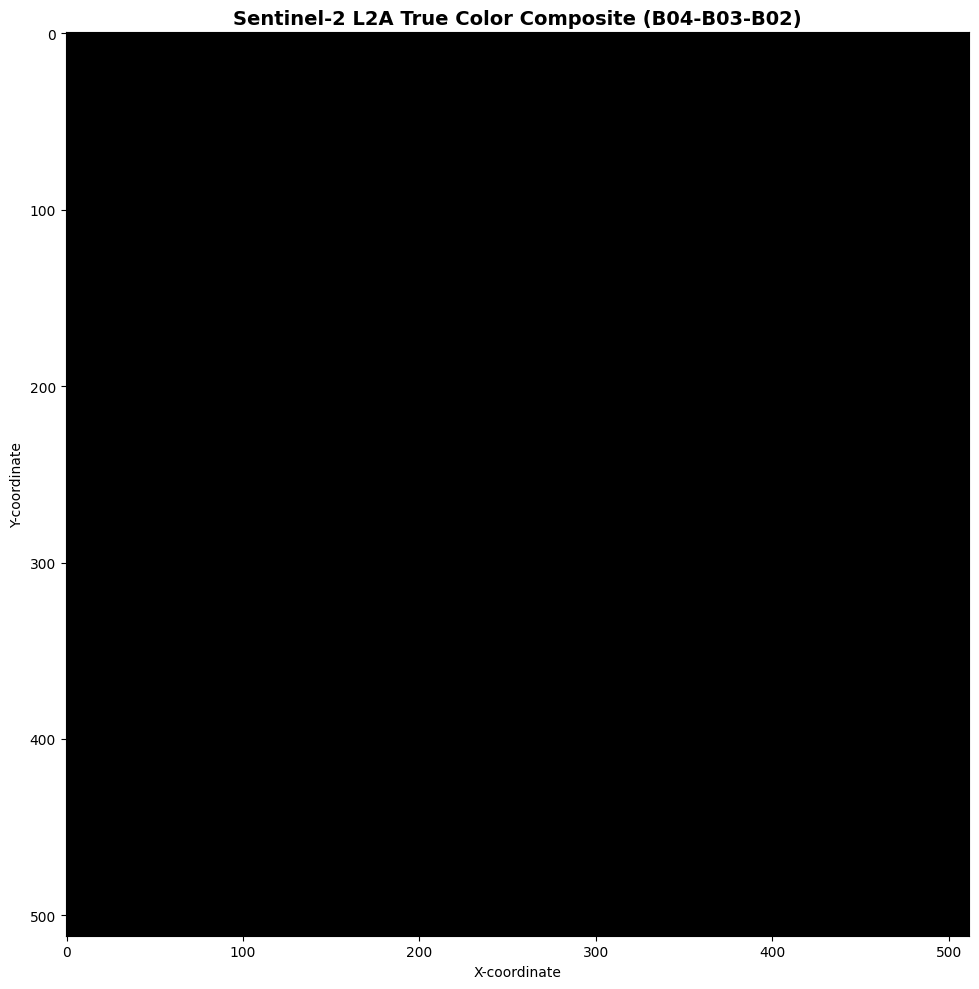

In [10]:
# Apply simple contrast stretch (2% linear stretch)
def stretch_rgb(data, lower_percentile=2, upper_percentile=98):
    """Apply percentile stretch to RGB data."""
    stretched = np.zeros_like(data, dtype=np.uint8)
    for i in range(3):
        band = data[i]
        p_low, p_high = np.percentile(band[band > 0], [lower_percentile, upper_percentile])
        band_stretched = np.clip((band - p_low) / (p_high - p_low) * 255, 0, 255)
        stretched[i] = band_stretched.astype(np.uint8)
    return stretched

# Stretch and visualize
# rgb_stretched = stretch_rgb(rgb_data.data)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_data.data_as_image())
plt.title('Sentinel-2 L2A True Color Composite (B04-B03-B02)', fontsize=14, fontweight='bold')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(False)
plt.tight_layout()
plt.show()

### Generate False Color Composite for Vegetation

False color composite using NIR-Red-Green (B08-B04-B03) highlights vegetation in red tones.

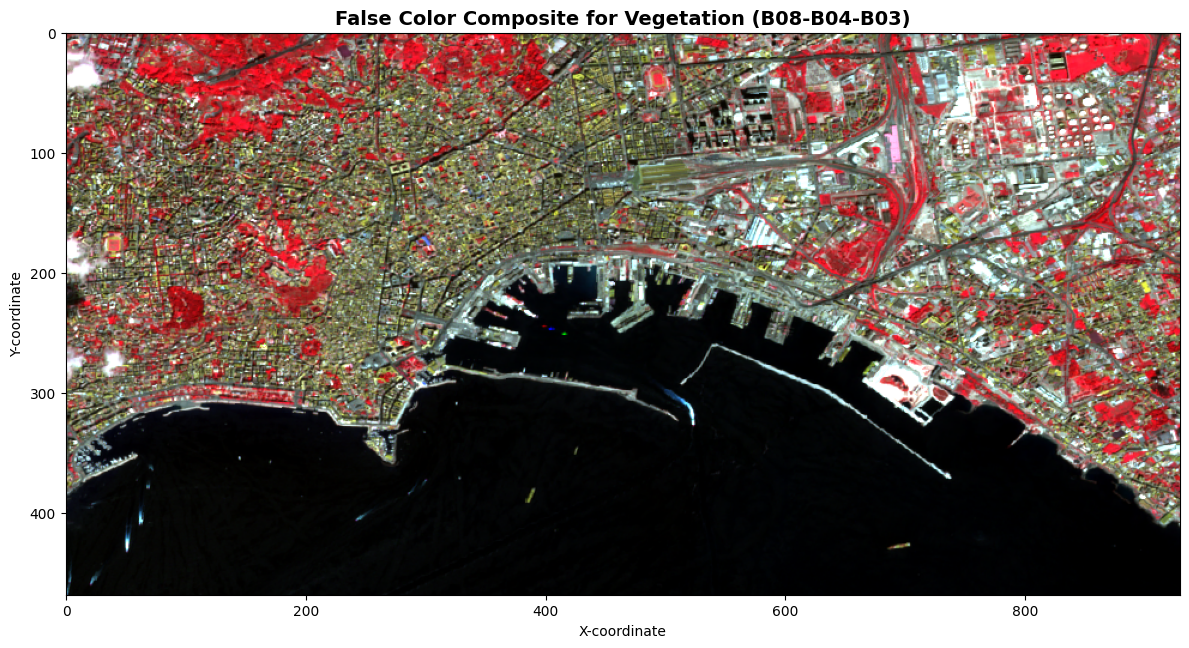


🌿 In this visualization:
   - Bright red areas = Dense, healthy vegetation
   - Dark red/brown = Sparse vegetation or bare soil
   - Blue tones = Urban areas, water bodies


In [11]:
# Create false color DataArray (NIR-Red-Green)
false_color_bands = xr.concat(
    [ds_10m['b08'], ds_10m['b04'], ds_10m['b03']],  # NIR, Red, Green
    dim='band'
).assign_coords(band=['nir', 'red', 'green'])

# Preserve CRS
false_color_bands = false_color_bands.rio.write_crs(ds_10m.rio.crs)

# Generate false color composite
with XarrayReader(false_color_bands) as src:
    false_color_data = src.part(
        bounds=src.bounds,
        max_size=1024,
        bbox=(14.219686024247595, 40.81406906961218, 14.322682850419474, 40.866016421491814)  # Napoli seafront area
    )

# Stretch and visualize
false_color_stretched = stretch_rgb(false_color_data.data)

plt.figure(figsize=(12, 10))
plt.imshow(np.transpose(false_color_stretched, (1, 2, 0)))
plt.title('False Color Composite for Vegetation (B08-B04-B03)', fontsize=14, fontweight='bold')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(False)
plt.tight_layout()
plt.show()

print("\n🌿 In this visualization:")
print("   - Bright red areas = Dense, healthy vegetation")
print("   - Dark red/brown = Sparse vegetation or bare soil")
print("   - Blue tones = Urban areas, water bodies")

# Section 3: Understanding the Data Flow

Let's examine how Zarr chunks relate to tile generation and performance.

### Chunk to Tile Relationship

Understanding how tiles map to Zarr chunks is crucial for optimization.

## Conclusion

In this notebook, we've learned:

1. ✅ How to integrate **rio-tiler** with EOPF Zarr datasets
2. ✅ Generated RGB and false color map tiles from Sentinel-2 data
3. ✅ Understood the critical relationship between Zarr chunks and tile performance
4. ✅ Observed memory usage patterns for different tile sizes
5. ✅ Learned about multi-resolution band handling strategies

### Key Takeaways

- **Chunk alignment matters**: Optimal performance requires matching chunk sizes to tile access patterns
- **EOPF Zarr is pre-optimized**: Default chunking (1830×1830 for 10m bands) balances storage and access efficiency
- **Memory scales with tile size**: Larger tiles require proportionally more memory
- **Rio-tiler simplifies tiling**: XarrayReader provides a clean interface for tile generation

**Completed in approximately 15-20 minutes ⏱️**

## What's Next?

In the next notebooks, we'll dive deeper into:

- **Notebook 2**: [Chunking Strategy Optimization with Sentinel-1 SAR](42_rio_tiler_s1_chunking.ipynb) - Systematic benchmarking of different chunk sizes
- **Notebook 3**: [Projections and TMS with Sentinel-3 OLCI](43_rio_tiler_s3_projections.ipynb) - Optimizing spatial reference systems for global datasets

### 💪 Try It Yourself

**Challenge 1**: Create a custom band combination (e.g., SWIR-NIR-Red for B12-B08-B04)

**Challenge 2**: Compare tile generation performance for different zoom levels

**Challenge 3**: Experiment with different chunk sizes by rechunking the dataset